In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

In [57]:
data = pd.read_csv("stock_price.csv")
data = data.iloc[::-1].reset_index(drop=True)

In [33]:
data

,Date,Close,Open,High,Low,Volume,Change %
0,1987-02-12,182.4,182.4,182.4,182.4,1.28B,16.25%
1,1987-02-13,172.5,176.5,176.5,172.5,422.38M,-5.43%
2,1987-02-16,175.5,166.7,175.5,165.7,360.51M,1.74%
3,1987-02-17,182.4,176.5,184.3,175.5,881.51M,3.93%
4,1987-02-18,191.2,186.3,191.2,186.3,795.09M,4.82%
...,...,...,...,...,...,...,...
9197,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%
9198,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
9199,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
9200,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%


In [36]:
# Converting string - Volume and Change in numerals
def convert_string_to_numeral(data):
    if data[-1] == "B":
        return float(data[:-1])*1000
    return float(data[:-1])

data.Volume = data.Volume.apply(convert_string_to_numeral)
data['Change %'] = data['Change %'].apply(convert_string_to_numeral)

### Step 1: Understanding the Data and EDA

In [37]:
# Summary Statistics
data.describe()

,Close,Open,High,Low,Volume,Change %
count,9202.000000,9202.000000,9202.000000,9202.000000,9202.000000,9202.000000
mean,92.180961,92.256183,93.176451,91.330146,172.667670,0.017502
std,50.452228,50.598215,51.049837,50.087405,125.127965,1.876667
min,33.000000,33.000000,33.200000,32.200000,9.340000,-14.740000
25%,52.000000,52.100000,52.800000,51.500000,80.730000,-0.940000
50%,85.100000,85.100000,86.050000,84.200000,154.015000,0.000000
75%,110.800000,110.800000,111.900000,109.275000,230.522500,0.900000
max,305.900000,309.800000,311.800000,303.900000,1280.000000,16.250000


In [38]:
# Check for Missing Values
data.isnull().sum()

Date        0
Close       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

In [39]:
def plot_column_with_sampling_and_moving_avg(data, column_name, date_interval=252, window_size=252):
    plt.figure(figsize=(10,6))

    x = list(data['Date'])
    y = list(data[column_name])

    plt.plot(x, y, label=column_name)

    moving_avg = data[column_name].rolling(window=window_size).mean()
    plt.plot(x, moving_avg, label=f'{window_size}-day Moving Avg', color='red')

    plt.title(f"{column_name} Over Time with {window_size}-day Moving Average")
    plt.xlabel('Date')
    plt.ylabel(column_name)
    
    plt.grid(True)
    plt.legend()
    
    sampled_dates = data['Date'][::date_interval]
    plt.xticks(ticks=sampled_dates.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

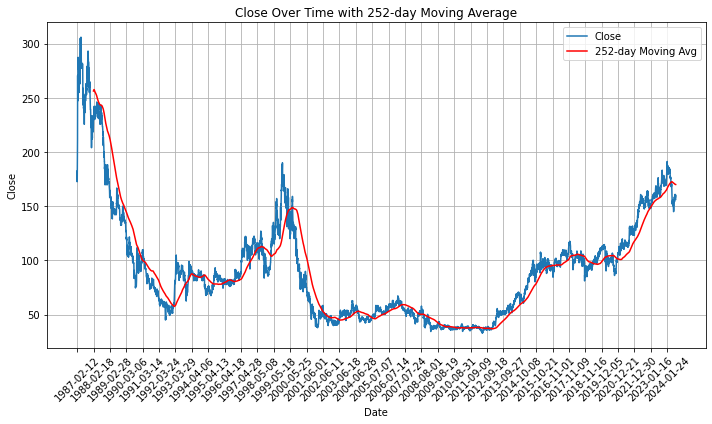

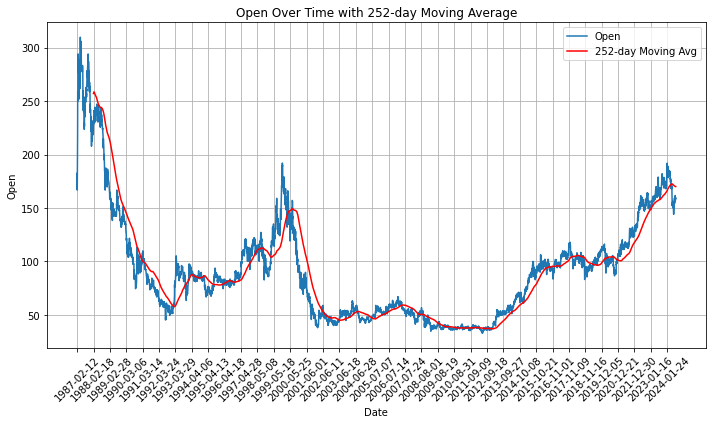

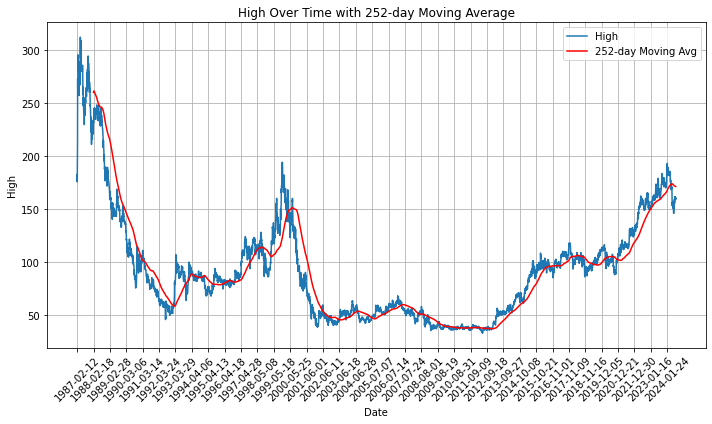

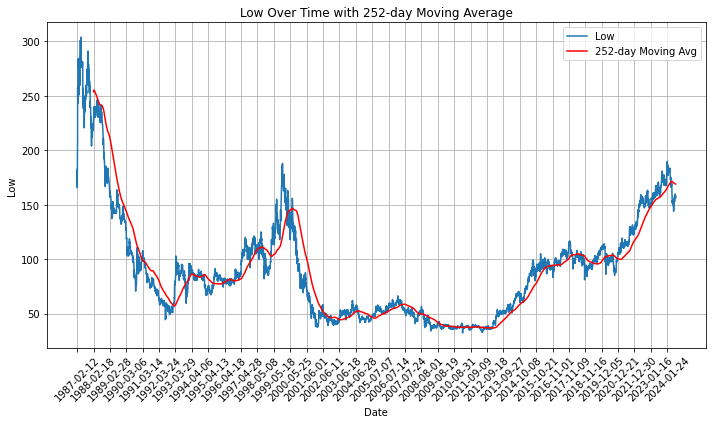

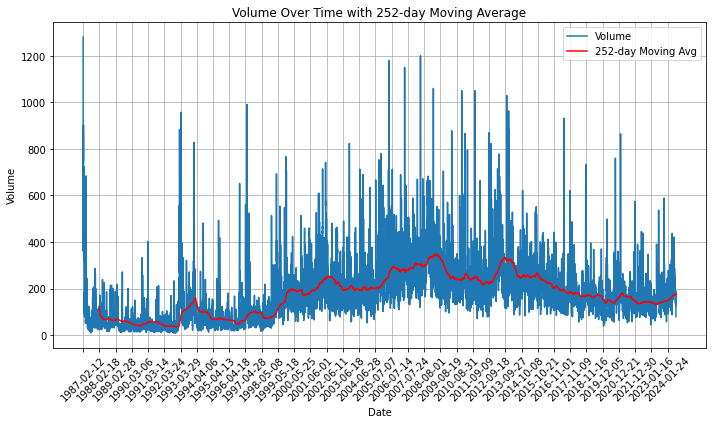

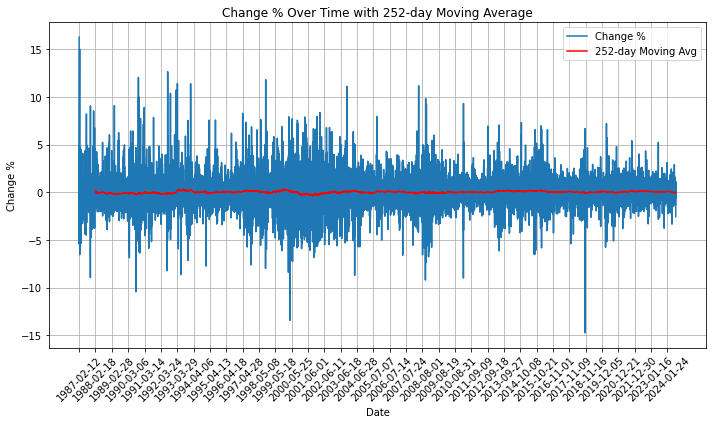

In [40]:
# Plotting the time series
for i in data.columns[1:]:
    plot_column_with_sampling_and_moving_avg(data, i, date_interval=252, window_size=252)

#### Observations from the graph:
1. Open, High, Low and Close are highly similar and correlated as they should be - confirmed by correlation score.
2. Instability in the market - as confirmed by research on Japanese Stock Market - starting in the late 1980s till the early 2000s
3. Volume traded has increased significantly in the new century compared to 1980s and 90s, reacing a high in 2013-14 and has since steadily decreased.

In [41]:
# Correlation Matrix
data.corr()

,Close,Open,High,Low,Volume,Change %
Close,1.000000,0.999547,0.999795,0.999754,-0.317508,0.017166
Open,0.999547,1.000000,0.999755,0.999791,-0.320279,-0.002860
High,0.999795,0.999755,1.000000,0.999660,-0.315402,0.007792
Low,0.999754,0.999791,0.999660,1.000000,-0.322392,0.005815
Volume,-0.317508,-0.320279,-0.315402,-0.322392,1.000000,0.130238
Change %,0.017166,-0.002860,0.007792,0.005815,0.130238,1.000000


### Observations from the Correlation Matrix
1. Open, High, Low, Close have high correlation amongst them
2. Volume has a moderate negative correlation wrt to prices - suggesting that lower prices caused more number of trades and vice versa
3. Change has no significant correlation with prices. A very small positive correlation with volume exists, however, nothing significant as such.

In [42]:
def plot_distributions(data, column_name):
    plt.figure(figsize=(8,6))
    sns.histplot(data[column_name], kde=True)
    plt.title(f'{column_name} Distribution')
    plt.show()


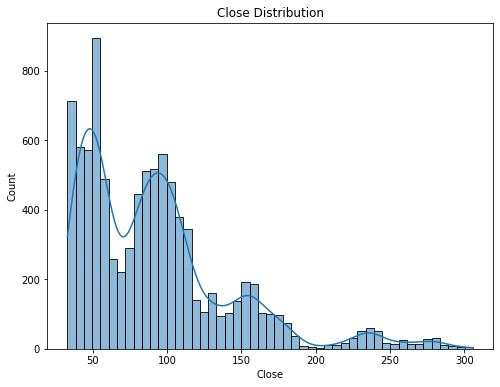

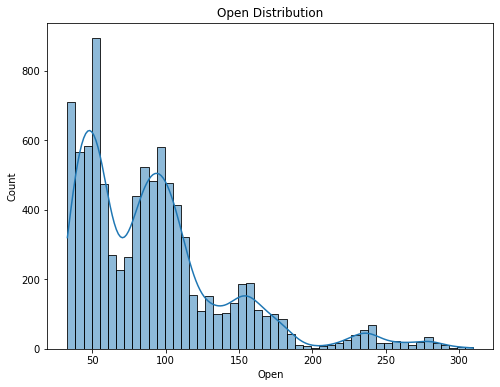

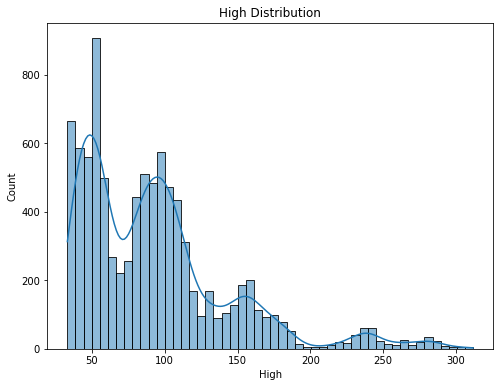

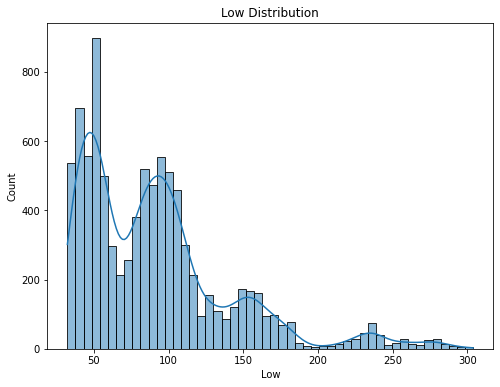

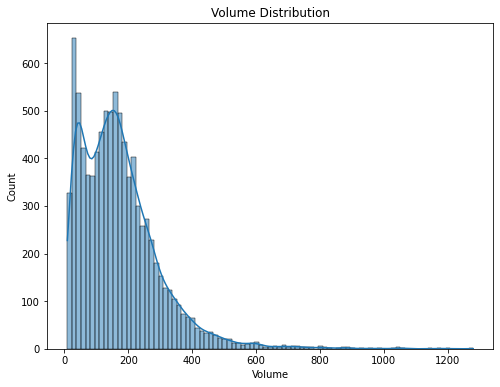

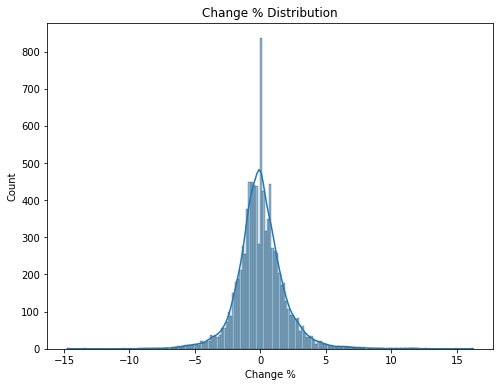

In [43]:
# Plotting the distribution of time series
for i in data.columns[1:]:
    plot_distributions(data, i)

### Distribution curves
1. Distribution curve for Change% is normal - as the assumption for many hypotheses for stock market usually is.

In [44]:
def seasonal_decomposition(i):
    result = seasonal_decompose(data[i], model='additive', period=252)

    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    plt.figure(figsize=(14, 10))

    plt.subplot(4, 1, 1)
    plt.plot(data['Date'], data[i], label='Observed')
    plt.title('Observed')
    plt.grid(True)
    plt.xticks(ticks=data['Date'][::252], rotation=45)

    plt.subplot(4, 1, 2)
    plt.plot(data['Date'], trend, label='Trend')
    plt.title('Trend')
    plt.grid(True)
    plt.xticks(ticks=data['Date'][::252], rotation=45)

    plt.subplot(4, 1, 3)
    plt.plot(data['Date'], seasonal, label='Seasonal')
    plt.title('Seasonal')
    plt.grid(True)
    plt.xticks(ticks=data['Date'][::252], rotation=45)

    plt.subplot(4, 1, 4)
    plt.plot(data['Date'], residual, label='Residual')
    plt.title('Residual')
    plt.grid(True)
    plt.xticks(ticks=data['Date'][::252], rotation=45)

    plt.tight_layout()
    plt.show()

Close


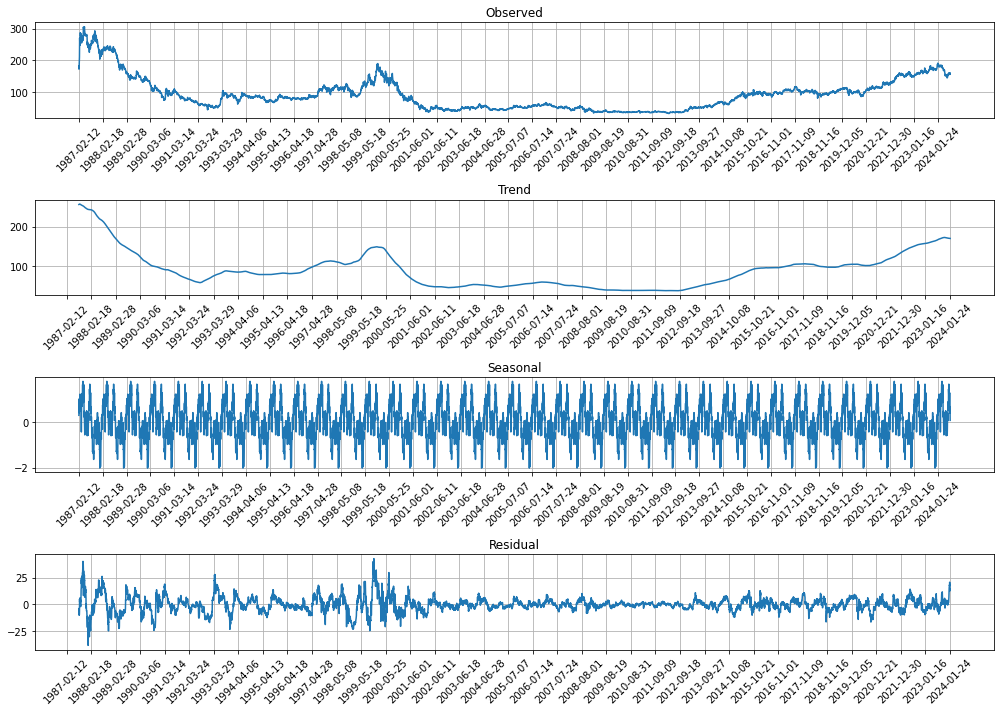

Open


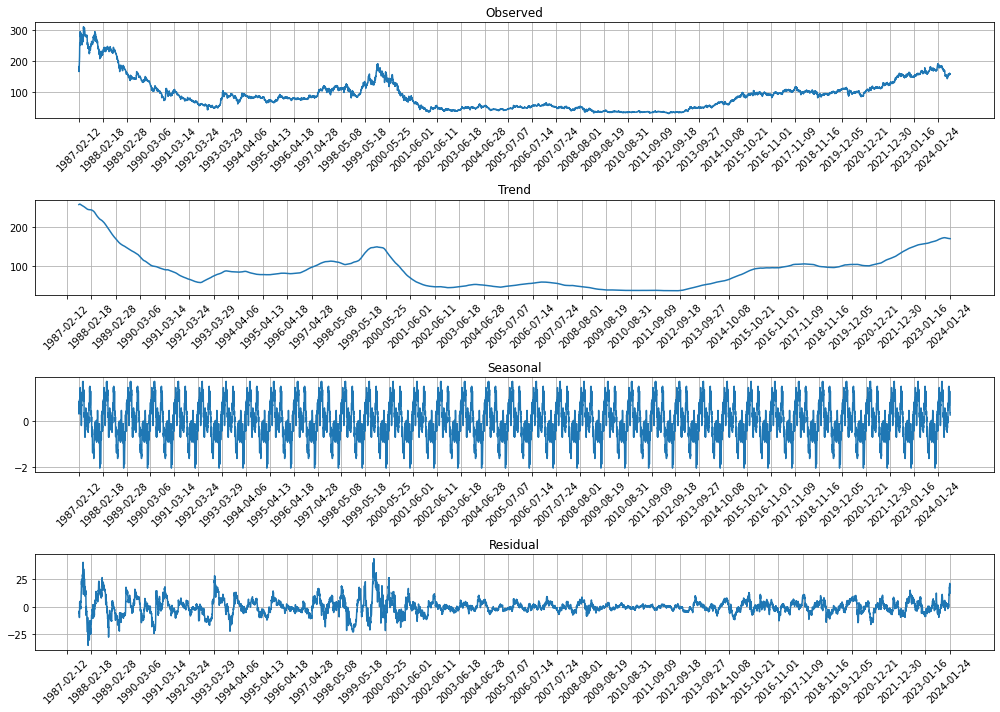

High


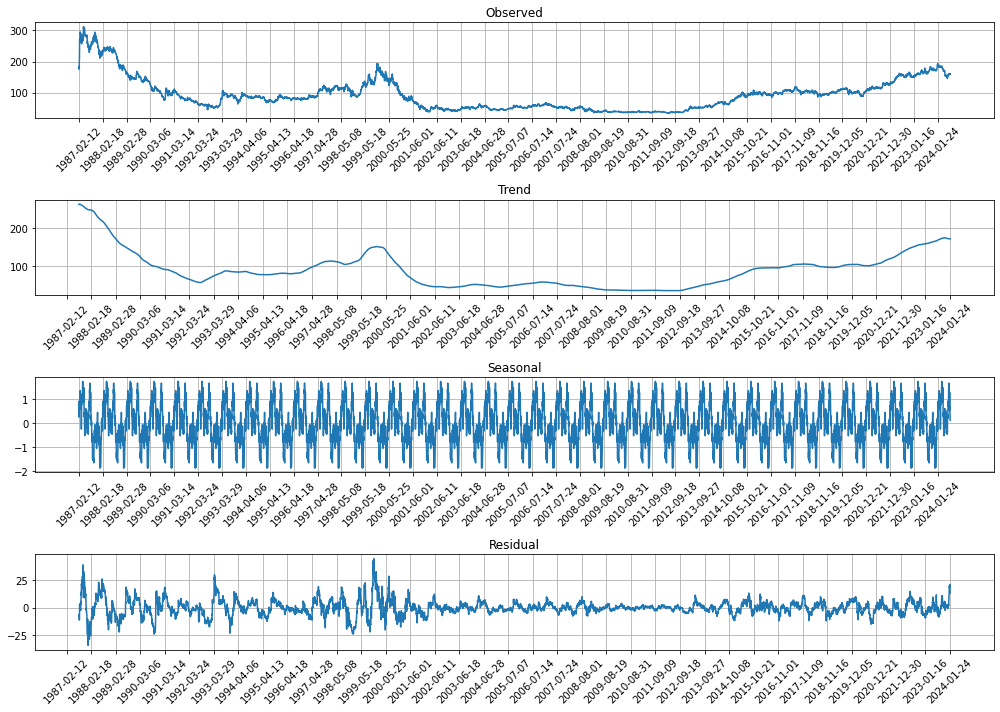

Low


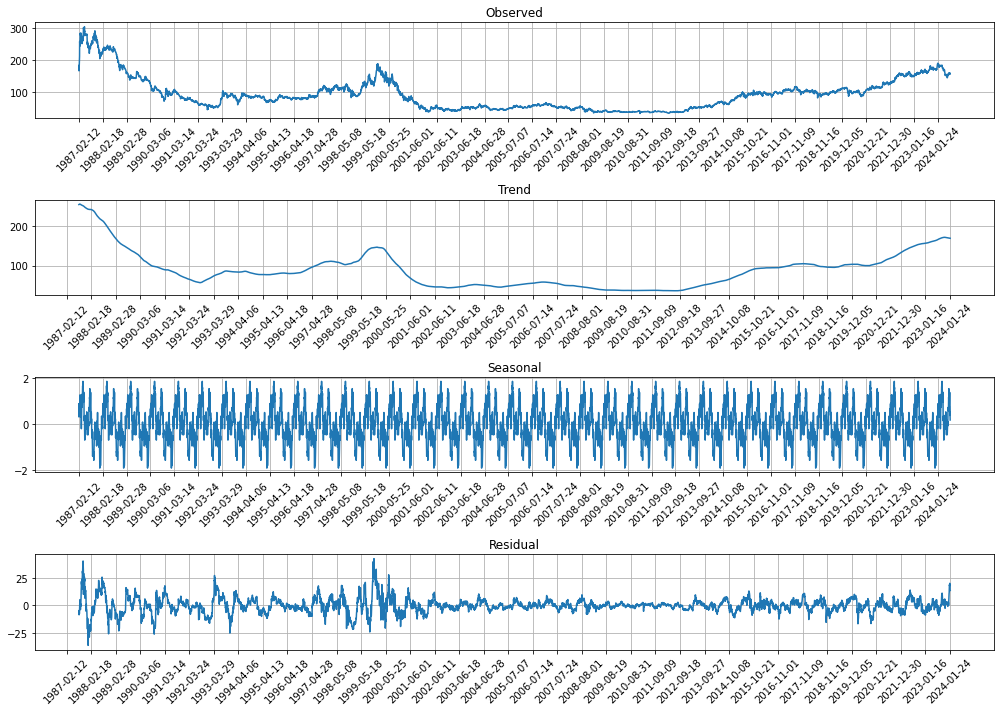

In [45]:
for i in data.columns[1:-2]:
    print(i)
    seasonal_decomposition(i)

### Seasonal Breakdown - Additive
Since all 4 are similar - we'll analyse just one of them and it should be representative of all 4
1. Trend, as seen earlier shows a curve where the price falls initially (87-92), seems to stabilise (93-99), falls sharply again (99-01) and has since been pretty stable
2. Seasonality is not very evident and ranges from a very small percentage (3-4% of the mean) of the data (-2 to +2)
3. The plot for Residual is interesting, as it highlights the period of instability by huge swings (87 - 01) and has since been pretty stable.

In [46]:
def detect_anomalies(data, window_size=504, z_threshold=4):
    anomalies = []
    
    for i in range(0, len(data) - window_size + 1):
        window_data = data[i:i+window_size]
        
        window_mean = np.mean(window_data)
        window_std = np.std(window_data)
        
        z_scores = (window_data - window_mean) / window_std
        
        for j in range(len(z_scores)):
            if abs(z_scores[j]) > z_threshold:
                anomalies.append(i + j)  

    return anomalies

close_prices = data['Close'].values  
anomaly_indices = detect_anomalies(close_prices)

anomalies_data = data.iloc[anomaly_indices]
print(anomalies_data)

            Date  Close   Open   High    Low  Volume  Change %
2530  1997-05-14  105.0  102.0  105.0  101.0  328.35      5.11
2530  1997-05-14  105.0  102.0  105.0  101.0  328.35      5.11
2532  1997-05-16  107.0  105.0  107.0  105.0  312.51      3.88
2532  1997-05-16  107.0  105.0  107.0  105.0  312.51      3.88
2533  1997-05-19  108.0  106.0  109.0  105.0  285.55      0.93
...          ...    ...    ...    ...    ...     ...       ...
6458  2013-05-15   55.5   53.9   56.5   53.8  596.11      4.13
6458  2013-05-15   55.5   53.9   56.5   53.8  596.11      4.13
6458  2013-05-15   55.5   53.9   56.5   53.8  596.11      4.13
6458  2013-05-15   55.5   53.9   56.5   53.8  596.11      4.13
6458  2013-05-15   55.5   53.9   56.5   53.8  596.11      4.13

[365 rows x 7 columns]


In [47]:
set(anomalies_data.Date)

{'1997-05-14',
 '1997-05-16',
 '1997-05-19',
 '1997-05-20',
 '1997-05-30',
 '1999-11-15',
 '2001-05-07',
 '2001-05-15',
 '2008-08-04',
 '2008-08-29',
 '2008-09-03',
 '2008-09-04',
 '2008-12-19',
 '2008-12-22',
 '2009-01-05',
 '2009-01-06',
 '2009-01-08',
 '2009-01-09',
 '2009-01-14',
 '2009-01-23',
 '2009-01-26',
 '2009-01-27',
 '2009-09-10',
 '2009-09-18',
 '2009-09-24',
 '2013-04-12',
 '2013-04-15',
 '2013-04-16',
 '2013-04-17',
 '2013-04-19',
 '2013-04-22',
 '2013-04-23',
 '2013-04-24',
 '2013-04-25',
 '2013-04-26',
 '2013-04-30',
 '2013-05-01',
 '2013-05-07',
 '2013-05-08',
 '2013-05-09',
 '2013-05-10',
 '2013-05-13',
 '2013-05-14',
 '2013-05-15',
 '2013-05-16',
 '2013-05-17',
 '2013-05-20',
 '2013-05-21',
 '2013-05-22'}

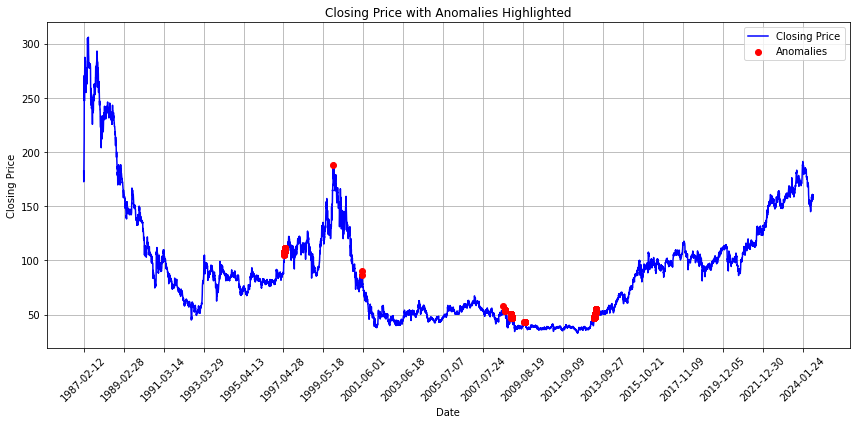

In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_anomalies_with_series(data, anomaly_indices, date_interval=252):
    plt.figure(figsize=(12, 6))
    
    plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
    plt.scatter(data['Date'].iloc[anomaly_indices], data['Close'].iloc[anomaly_indices], 
                color='red', label='Anomalies', zorder=5)
    
    plt.title('Closing Price with Anomalies Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    
    sampled_dates = data['Date'][::date_interval]
    plt.xticks(ticks=sampled_dates.index, labels=sampled_dates, rotation=45)
    
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

anomaly_indices = detect_anomalies(close_prices, window_size=504)
anomalies_data = data.iloc[anomaly_indices]
plot_anomalies_with_series(data, anomaly_indices, date_interval=504)

### Anomalies
The threshold for Z-Score has been kept as 4 to highlight only the most evident anomalies
To Calculate Mean and Deviation - Used to calculate Z-Score, I have used a 504 days window instead of the full time frame to neutralise the effect due to trends
Three important timelines come into the light:
1. 1997 May - Just before the Asian Financial Crisis
2. 2008 - World Wide Financial Crisis 
3. 2013 - Best performing year for Japanese Market - 57% rise